# Importation des librairies

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importer les données

In [177]:
data = pd.read_csv('./data2.csv', sep=";")

## Mise en forme Série Temporelle

In [178]:
#  Séléectionner les bonnes colonnes
data = data.iloc[:, [0, 1, 6]].to_numpy()

# Mettre en Serie temporelle
time_serie = pd.Series(data[:, 2], dtype='float64')

# Retirer les valeurs vides
time_serie = time_serie.dropna()

# Afficher la série temporelle

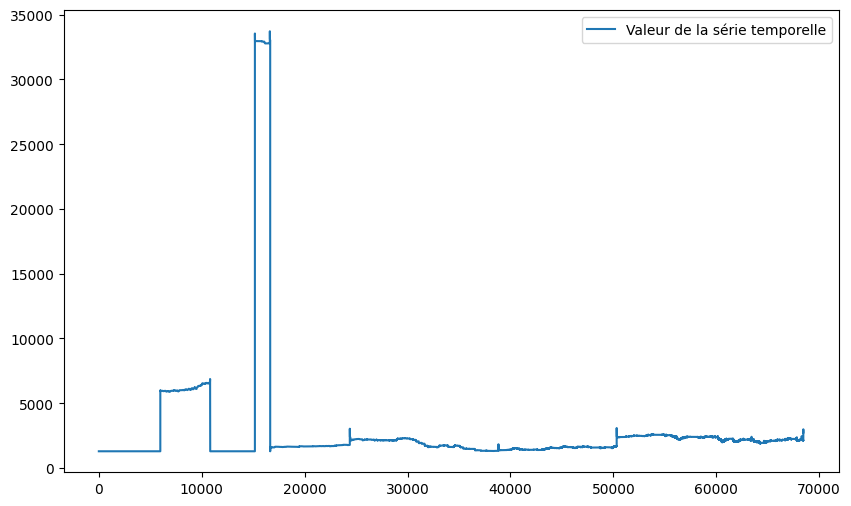

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues
Sur le début de la plage de données, on observe des pallier de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur une autres valeurs. 
Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

## On enlève le début

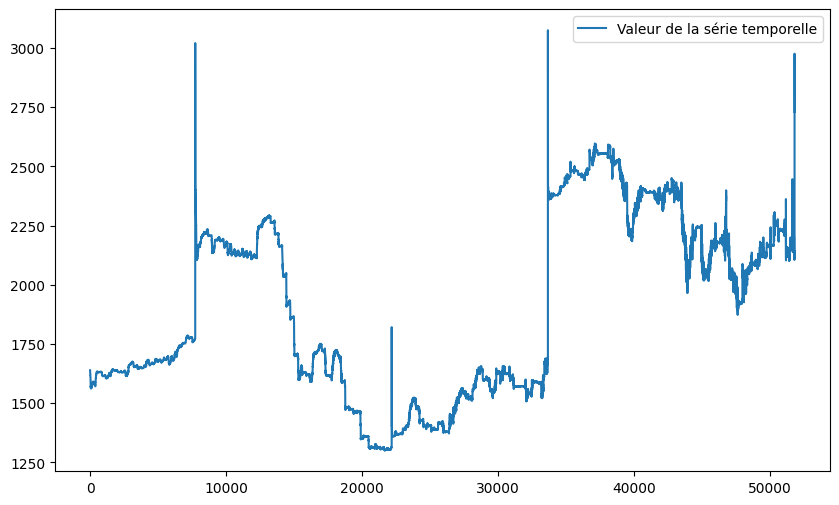

In [180]:
data_crop = data[16656:, 2]

time_serie_crop = pd.Series(data_crop, dtype='float64')
plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

## On enlève les pics

### On detecte où sont les pics 

In [181]:
def detect_pic(arr, seuil=100):
    pic_indices = []
    for i in range(1, len(arr) - 1):
        if arr[i] < arr[i + 1] - seuil or arr[i] > arr[i + 1] + seuil:
            pic_indices.append(i-1)
    return pic_indices

indices = detect_pic(data_crop)

print("Indices des pics :", indices)
print("Valeurs des pics :", data_crop[indices])

Indices des pics : [7731, 7732, 7733, 7734, 22176, 22177, 33664, 33665, 33666, 33667, 45006, 45980, 46697, 46779, 50272, 51164, 51165, 51166, 51167, 51642, 51643, 51644, 51645, 51801, 51802, 51803, 51805]
Valeurs des pics : [1773 1773 2325 3021 1313 1313 1671 1676 3075 2778 2089 2161 2103 2363
 2166 2249 2251 2123 2362 2258 2213 2342 2206 2117 2130 2976 2488]


In [192]:
def delete_pic(arr, indices) :
    data_clean = arr
    for i in indices:
        data_clean = [x - arr[i-1] for x in arr[i:]]
        print(i,arr[i])
    return data_clean

### On interpole

7731 1773
7732 1773
7733 2325
7734 3021
22176 1313
22177 1313
33664 1671
33665 1676
33666 3075
33667 2778
45006 2089
45980 2161
46697 2103
46779 2363
50272 2166
51164 2249
51165 2251
51166 2123
51167 2362
51642 2258
51643 2213
51644 2342
51645 2206
51801 2117
51802 2130
51803 2976
51805 2488


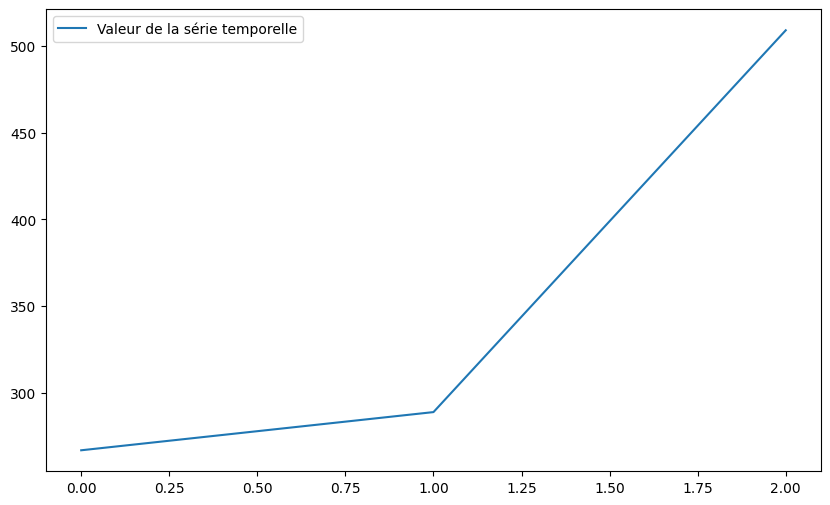

In [193]:
data_clean = delete_pic(data_crop,indices)

time_serie_clean = pd.Series(data_clean, dtype='float64')

plt.figure(figsize=(10, 6))
plt.plot(time_serie_clean, label='Valeur de la série temporelle')
plt.legend()
plt.show()

# Première modélisation naïve

In [9]:
# SARIMA parameters
p, d, q = 1, 1, 1    
P, D, Q, s = 1, 1, 1, 96  # Seasonality every 96 time steps

# Building the SARIMA model
model = SARIMAX(time_serie, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Display the model summary
print(model_fit.summary())

KeyboardInterrupt: 